In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d

,Nifty_50_1d_return,Dow_Jons_1d_return,SPX_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,Bank_Nifty_1d_return,Nifty_IT_1d_return,Nifty_Auto_1d_return,Nifty_Metal_1d_return,Nifty_FMGC_1d_return,Nifty_Energy_1d_return,NIFTY_FIN_SERVICE_1d_return,Nifty_Infra_1d_return,Nifty_CMDT_1d_return,Nifty_Consumer_1d_return
Date,,,,,,,,,,,,,,,,,,,
08-09-11,-0.53,-1.42,-1.37,-1.26,-1.42,-1.81,-1.74,-1.00,-2.71,-0.70,8.26,0.42,-1.46,-0.27,-0.34,-1.00,-0.83,-0.81,-1.19
13-09-11,-0.95,-0.36,0.31,0.35,-0.30,1.97,-1.37,0.01,-2.73,-0.80,-1.27,1.72,0.03,-0.86,-1.16,0.42,-0.88,-0.26,0.88
14-09-11,-13.25,2.14,0.48,0.07,-2.42,-0.68,-1.19,-0.43,-0.88,-3.40,3.66,-0.71,-1.07,-91.91,3.21,-0.79,0.02,-1.14,-0.63
15-09-11,-0.13,0.31,0.28,-0.16,4.74,2.96,12.66,-0.67,6.38,0.40,-0.46,-5.15,8.29,-1.20,-0.03,-2.90,-2.51,5.99,-3.54
16-09-11,-0.87,-0.60,-0.67,-0.56,-2.03,-1.12,-1.77,-1.60,-1.58,-0.69,-1.44,-0.69,-0.91,3.86,-0.64,1.62,0.43,-0.60,-1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24-04-23,-299.38,1.97,-0.06,-3.73,0.90,-3.49,-1.35,-0.55,22.50,-4.43,0.03,-0.96,-1.33,-0.35,108.75,-7.56,-2.08,-1.79,3.18
25-04-23,-0.78,-6.18,-19.57,5.77,-2.81,1.43,-0.49,1.22,-2.09,-0.92,-1.14,-3.07,0.37,-0.60,7.12,-1.13,0.35,-0.27,0.05
26-04-23,0.71,-0.33,-0.76,-1.24,0.61,-1.26,-2.69,-1.70,-1.76,2.54,-3.85,5.08,-1.71,2.08,-1.11,-2.33,-0.39,-1.47,0.29


In [3]:
# Add lagged returns as features
return_1d['Nifty_IT_1d_return'] = return_1d['Nifty_IT_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_IT_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_IT_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_IT_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_IT_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_IT_1d_return'] >= lower_bound) & (return_1d['Nifty_IT_1d_return'] <= upper_bound)]
np.random.seed(42)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_2164\488441003.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_1d['return_squared'] = return_1d['Nifty_IT_1d_return'] ** 2
C:\Users\Harsh\AppData\Local\Temp\ipykernel_2164\488441003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_1d['return_lag_interaction'] = return_1d['Nifty_IT_1d_return'] * return_1d['Nifty_50_1d_return_lag1']


In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
Date                                                                  
14-09-11              -13.25                2.14               0.48   
16-09-11               -0.87               -0.60              -0.67   
19-09-11               -7.11               -2.41              -2.72   
20-09-11               -3.09               -1.07              -0.83   
21-09-11               -1.06              -38.08              16.69   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
14-09-11              0.07            -2.42               -0.68   
16-09-11             -0.56            -2.03               -1.12   
19-09-11             -1.62             0.01               13.07   
20-09-11              1.39            -1.47               -1.08   
21-09-11              1.32            -1.13               -7.96   

          Gold_1d_

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
count         1783.000000         1783.000000        1783.000000   
mean            -1.494992           -4.671038           0.407981   
std             74.761632          110.126527          44.463988   
min          -2807.010000        -3606.010000        -363.000000   
25%             -1.905000           -1.925000          -2.020000   
50%             -0.890000           -1.000000          -1.000000   
75%              0.135000           -0.060000          -0.085000   
max            904.410000          354.210000        1128.740000   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       1783.000000      1783.000000         1783.000000     1783.000000   
mean          -2.959355        -1.971520           -1.005238       -0.731144   
std           65.953613        21.013344            2.349988       12.630735   
min        -1517.720000      -273.9

In [6]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_IT_1d_return'].sort_values())
nifty_corr_1d

,Nifty_IT_1d_return
return_squared,-0.622605
Gold_1d_return,-0.084238
Nifty_CMDT_1d_return,-0.048798
Bank_Nifty_1d_return,-0.043657
Dollar_Index_1d_return,-0.035410
Nifty_Metal_1d_return,-0.021717
NIFTY_FIN_SERVICE_1d_return,-0.014811
Nifty_Auto_1d_return,-0.013278
Nifty_FMGC_1d_return,-0.007457
SPX_500_1d_return,-0.002966


<Axes: >

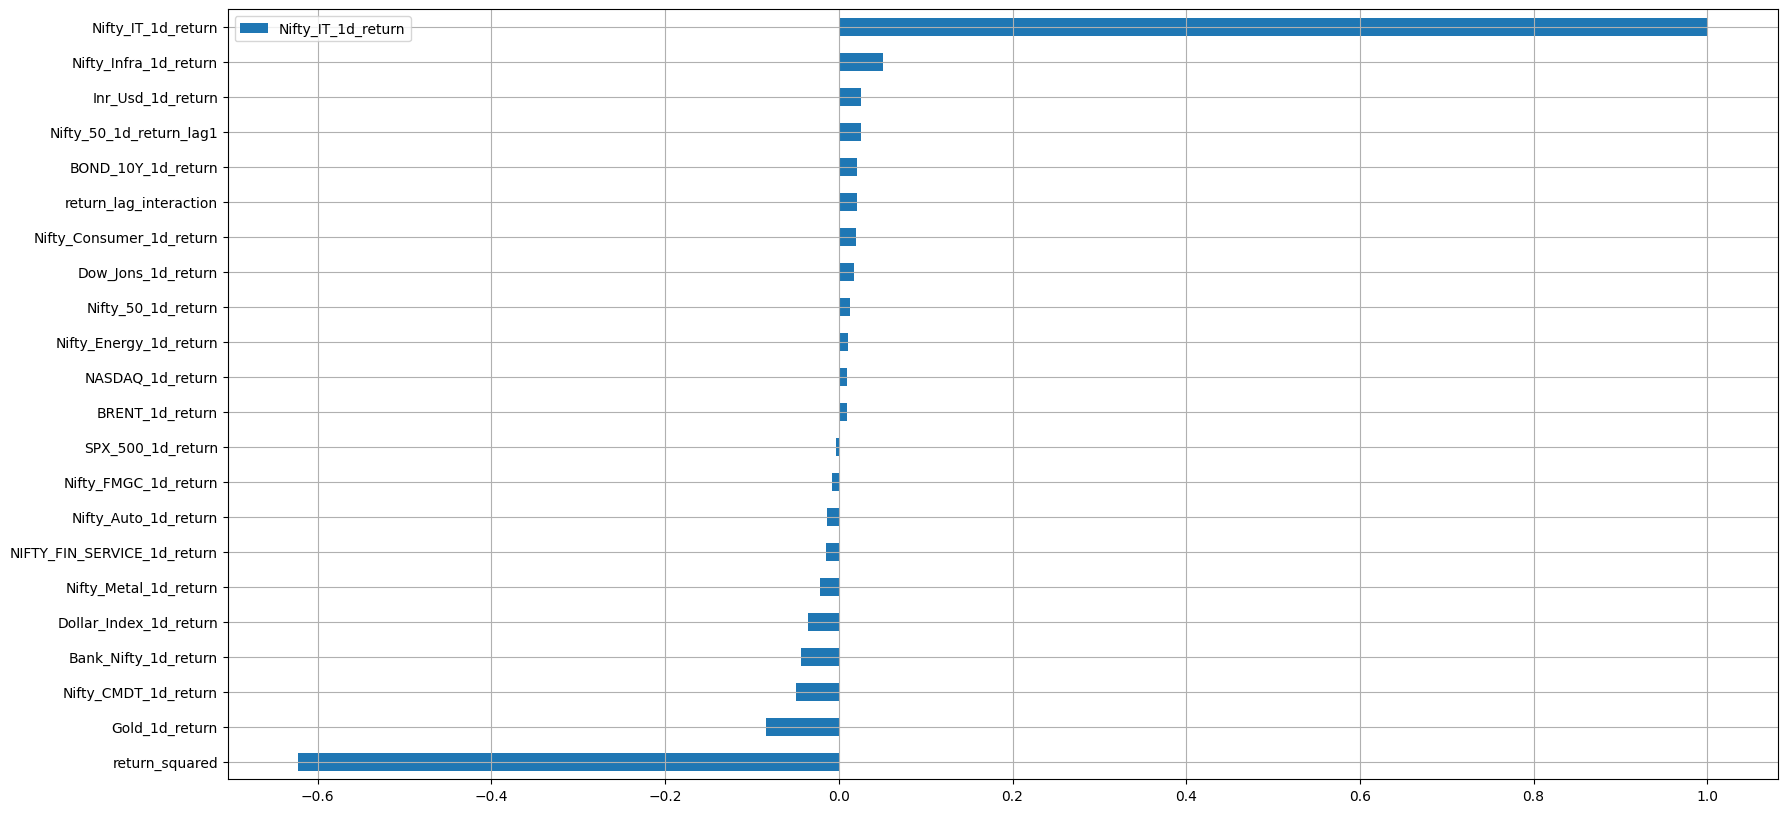

In [7]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k=10)
X = return_1d.drop(columns='Nifty_IT_1d_return')
y = return_1d['Nifty_IT_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Dow_Jons_1d_return', 'NASDAQ_1d_return', 'Gold_1d_return',
       'Bank_Nifty_1d_return', 'Nifty_Metal_1d_return',
       'Nifty_Infra_1d_return', 'Nifty_CMDT_1d_return',
       'Nifty_50_1d_return_lag1', 'return_squared', 'return_lag_interaction'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_IT_1d_return')
y = return_1d['Nifty_IT_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[ 6.03206224e-02 -1.16879295e-02 -4.90097764e-02 -3.12136794e-01
  -3.00716697e-02 -5.48603392e-02 -4.89438205e-02  3.74651499e-03
   5.43016829e+00  8.64423567e-03]
 [-1.37059234e-02  1.32393111e-01  1.90972100e-02 -1.59375024e-02
   1.90990588e-02  5.01429710e-02 -2.59876879e-02 -4.03206361e+00
  -7.42304676e-01 -8.79336767e-02]
 [ 3.94296954e-02  2.60764695e-02 -1.55129964e-01  2.76042426e-01
  -4.10627737e-02  1.81666543e-02 -4.41109505e-02  7.66989984e-03
  -3.76293642e-01 -1.97885668e-02]
 [ 1.23623203e-02  1.08430159e-01 -6.16808436e-02  7.26691233e-02
  -6.76728150e-02  6.22421178e-02 -9.96889557e-02  2.78279806e-02
   3.43484873e+00 -4.47991325e-02]
 [ 3.79764135e-02  3.41146749e-02 -1.73321083e-02  9.20781937e-02
   1.18680693e-02  9.33542097e-02 -6.80723498e-03  3.55394612e-02
   1.23658427e+00 -2.50961916e-03]]
Date
24-04-23   -4.68
25-04-23    0.03
26-04-23   -1.14
27-04-23   -3.85
28-04-23    2.65
Name: Nifty_IT_1d_return, dtype: float32


Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.2979
R2: 0.8581

For RFR:
MSE: 0.1006
R2: 0.9521

For ETR:
MSE: 1.0372
R2: 0.5061

For GBR:
MSE: 0.3073
R2: 0.8537

For XGBR:
MSE: 0.0422
R2: 0.9799



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is XGBR with an MSE of 0.0422.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

The best model is XGBR with an MSE of 0.0422.

In [16]:
y_pred = gbr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
27-10-17,-2.04,-1.392787
14-09-21,1.63,0.818852
25-02-13,-2.65,-0.945422
23-08-17,-1.05,-1.006221
17-07-17,-3.80,-3.790602
...,...,...
17-10-17,-0.13,-0.270057
29-12-14,0.56,0.280710
24-01-14,-2.53,-2.065469


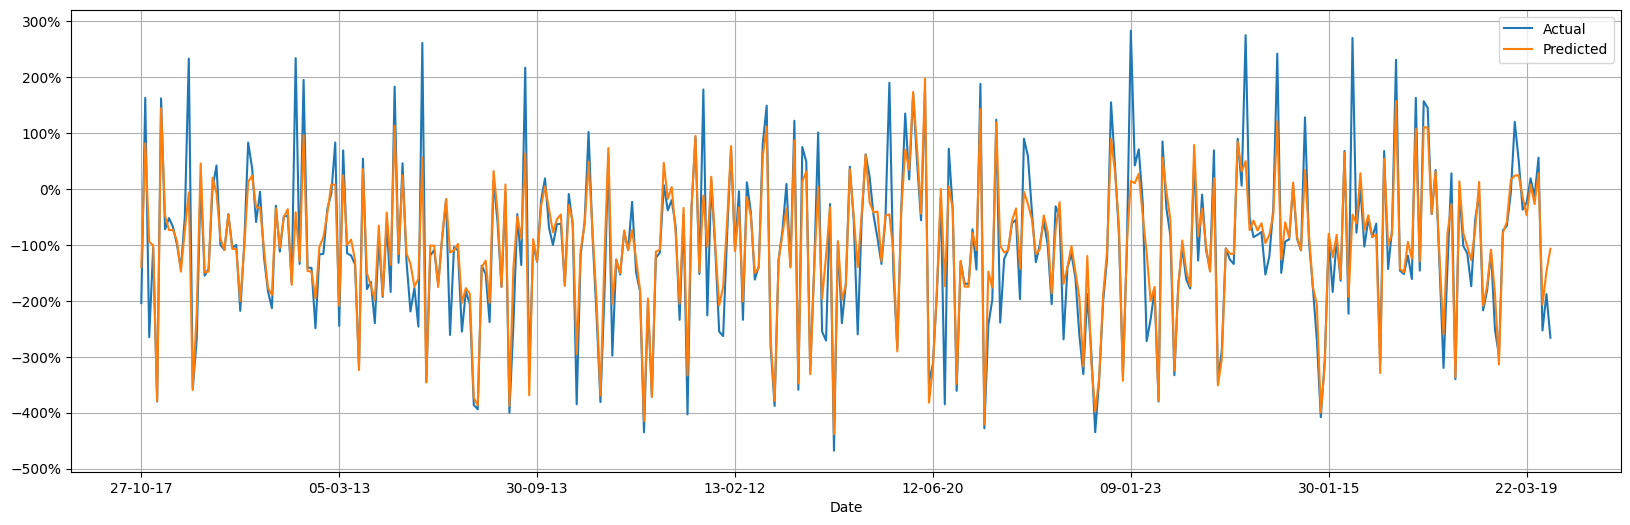

In [17]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_2164\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_IT_1d_return', ylabel='Density'>

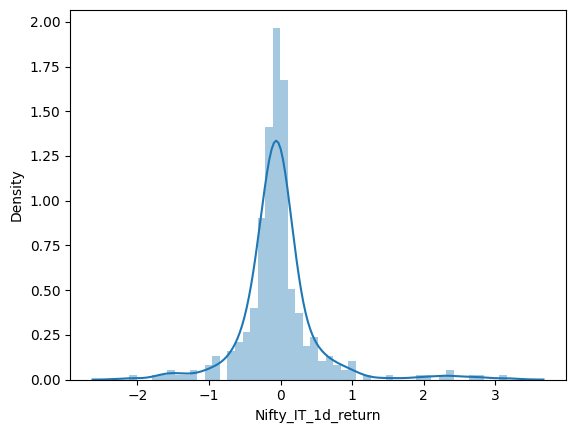

In [18]:
sns.distplot(y_test-y_pred)

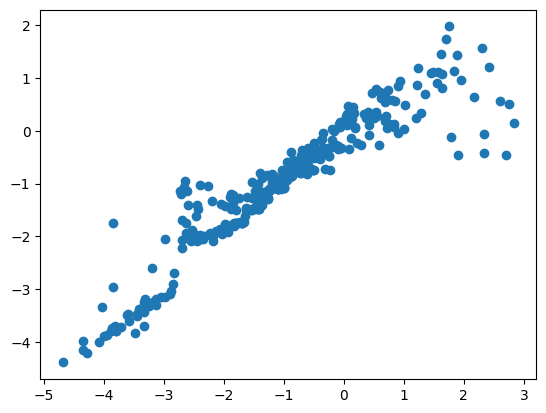

In [19]:
plt.scatter(y_test,y_pred)
